In [156]:
import torch
import torch.nn as nn
from torch import optim
import torchaudio
import random
import numpy as np
import matplotlib.pyplot as plt

torch.autograd.detect_anomaly(True)  #Was here for because of exploding gradients and trying to isolate cause of NaN

<ipython-input-156-28b042529b55>:9: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  torch.autograd.detect_anomaly(True)  #Was here for because of exploding gradients and trying to isolate cause of NaN


In [78]:
torch.autograd.set_detect_anomaly(False)

In [24]:
class AudioRNN(nn.Module):  #Model based largely off of pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
    def __init__(self, input_size, hidden_size, output_size):
        super(AudioRNN, self).__init__()

        self.hidden_size = hidden_size

        self.hid = nn.Linear(input_size + hidden_size, hidden_size)
        self.out = nn.Linear(input_size + hidden_size, output_size)
       # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.hid(combined)
        output = self.out(combined)
       # output = self.softmax(output)
        return output, hidden


In [25]:
def preprocess(inp):
    return preprocess(inp, 0, inp.shape[1])

def preprocess(inp, start_index, length):   #This applies all preprocessing for the input
    if inp.shape[0] == 2:       #If data is stereo, convert to mono
      input = ((inp[0] + inp[1])/2).reshape((1, inp.shape[1]))
    else:
      input = inp

    input = input[0][start_index:start_index + length + 1]      #Extract the data to convert
    mu = 255
    convData = np.sign(input)*(np.log(1 + mu * np.abs(input)))/(np.log(1+mu))   #mu law quantization
    convData = (convData + 1) * 255 / 2
    convData = convData.type(torch.int64)
    inputData = np.zeros((convData.shape[0], 256))    #convert to one hot encoding
    for i in range(inputData.shape[0]):
        inputData[i][convData[i]] = 1

    return torch.from_numpy(inputData.reshape(inputData.shape[0], 1, 256))


In [122]:
def postprocess(data):    #post processing of data after passing through softmax and onehot encoding
  unmapped = (torch.argmax(data, dim = 2) * 2 / 255) - 1    #Remap to -1 to 1
  mu = 255
  rawConverted = torch.sign(unmapped) * (1/mu) * (torch.pow((1 + mu), torch.abs(unmapped)) - 1)   #inverse mu law quantization
  return rawConverted.transpose(0, 1)

In [60]:
n_hidden = 128        #Create Model
rnn = AudioRNN(256, n_hidden, 256)
#hidden_state = torch.zeros(1, 128)
#output, next_hidden = rnn(inputData[0], hidden_state)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr = 0.0001, weight_decay = 0.01) 


# Training

In [61]:
y, fr  = torchaudio.load('/content/Dataset.wav')    #Load training audio file
losses = []


In [125]:
#Now we Train (Let's do random 3 second clips at a time, this is fr * 3 in length)
training_segments = 1000
segment_duration = 3

#data = preprocess(y).cuda() CAUSES CRASHING DUE TO LARGE DATASET AND INEFFICIENT PREPROCESSING
rnn.train()
for i in range(training_segments):
    print(i)
    start_index = random.randint(0, y.shape[1] - (fr * segment_duration) - 1)     #Select random 'segment_duration' long sequences from the data
    data = preprocess(y, start_index, fr * segment_duration).type(torch.float32)
    hidden_state = torch.zeros(1, n_hidden)

    for j in range(fr * segment_duration):    #Pass sequence to RNN to build hidden state
        #output, hidden_state = rnn(data[j + start_index], hidden_state)
        output, hidden_state = rnn(data[j], hidden_state)

    #loss = loss(output, data[fr * segment_duration + start_index])
    loss = loss_func(output, data[fr * segment_duration])
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm(rnn.parameters(), 0.3)    #Gradient Clipping because of exploding gradients
    optimizer.step()
    print(loss.item())
    losses.append(loss.item())


0


<ipython-input-125-7e9149992051>:21: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(rnn.parameters(), 0.3)    #Gradient Clipping because of exploding gradients


5.553612232208252
1
5.5101094245910645
2
5.545891284942627
3
5.563125133514404
4
5.544564247131348
5
5.503601551055908
6
5.520017623901367
7
5.48555326461792
8
5.581744194030762
9
5.505847454071045
10
5.522484302520752
11
5.465758323669434
12
5.477099418640137
13
5.568143844604492
14
5.570852279663086
15
5.571117877960205
16
5.4846720695495605
17
5.575399875640869
18
5.504697799682617
19
5.475525856018066
20
5.478820323944092
21
5.577420234680176
22
5.514196872711182
23
5.420507907867432
24
5.490921974182129
25
5.5571980476379395
26
5.530087947845459
27
5.4860005378723145
28
5.573886394500732
29
5.552030563354492
30
5.558830261230469
31
5.5445237159729
32
5.564621448516846
33
5.571801662445068
34
5.4849019050598145
35
5.493241310119629
36
5.487499713897705
37
5.512500762939453
38
5.500206470489502
39
5.483339309692383
40
5.554531097412109
41
5.543227672576904
42
5.556952476501465
43
5.5686163902282715
44
5.472179412841797
45
5.511355400085449
46
5.504196643829346
47
5.493656158447266
4

KeyboardInterrupt: ignored

In [126]:
torch.save(rnn, "trained_model")  #Save model to load later

Text(0.5, 0, 'Sample')

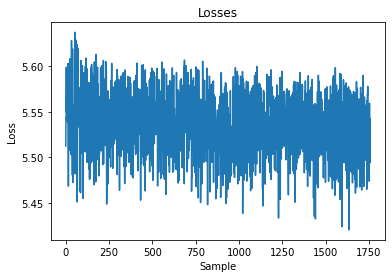

In [172]:
plt.plot(losses)
plt.title("Losses")
plt.ylabel("Loss")
plt.xlabel("Sample")

# Audio Generation

In [130]:
from google.colab import files
uploaded = files.upload()


Saving Dataset.wav to Dataset (1).wav


In [ ]:
y, fr  = torchaudio.load('/content/Dataset.wav')

In [150]:
data = preprocess(y, 50*fr, 5*fr).type(torch.float32)

In [103]:
#checkpoint = torch.load("final")
#rnn = AudioRNN(256, n_hidden, 256)
#rnn = (checkpoint)


In [168]:
rnn = torch.load("trained_model") #Can be found in github repo
rnn.eval()
n = nn.Softmax()
hidden_state = torch.zeros(1, n_hidden)
out = None
genLength = 5 #seconds of audio to generate
genData = torch.zeros((fr*genLength + 1, 1, 256))

for i in range(data.shape[0]):    #Build hidden_state from input data
  out, hidden_state = rnn(data[i], hidden_state)
  oneHotOut = torch.zeros((1, 256))
  oneHotOut[0][n(out).argmax()] = 1
  genData[0] = oneHotOut

for i in range(fr * genLength):
  out, hidden_state = rnn(data[i], hidden_state)
  oneHotOut = torch.zeros((1, 256))
  oneHotOut[0][n(out).argmax()] = 1

  genData[i + 1] = oneHotOut
  out = oneHotOut




<ipython-input-168-4bfb13eb2758>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  oneHotOut[0][n(out).argmax()] = 1
<ipython-input-168-4bfb13eb2758>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  oneHotOut[0][n(out).argmax()] = 1


In [169]:
torchaudio.save(f'InputCatGenOutput.wav', postprocess(torch.cat((data, genData))), sample_rate=fr)
